## 하이퍼 파라미터 튜닝

In [3]:
# 결정나무 타이타닉 생존자 예측 모델 결과 - 데이터 불러오기
import pandas as pd

titanic = pd.read_csv('./titanic.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(titanic['sex'])
titanic['gender'] = le.transform(titanic['sex'])

In [5]:
titanic = titanic[titanic['age'].notnull()]
titanic = titanic[titanic['fare'].notnull()]

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = titanic[['pclass', 'age', 'sibsp', 'parch', 'fare', 'gender']].values
y = titanic['survived'].values

SS = StandardScaler()
SS.fit(X)

X_ss = SS.transform(X)

X_train, X_test, y_train, y_test = \
train_test_split(X_ss, y, test_size = 0.2, random_state = 13)

In [7]:
# Test Accuracy가 75%
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 2, random_state = 13)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)
print(accuracy_score(y_test, pred))

0.7559808612440191


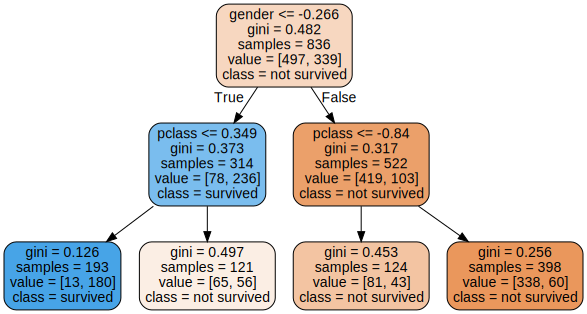

In [8]:
# 결정나무를 구성하는 depth
from graphviz import Source
from sklearn.tree import export_graphviz

Source(export_graphviz(dt, feature_names = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'gender'],
                       class_names = ['not survived', 'survived'],
                       rounded = True, filled = True))

In [9]:
# 튜닝할 파라미터 선정
# depth를 2,3,4,5로 하고, 노드를 분리하기 위한 최소의 샘플을 2,3,4로 했음
# 이렇게 하면 총 12개의 경우의 수로 학습을 반복함
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2, 3, 4, 5], 'min_samples_split':[2, 3, 4]}
grid_clf = GridSearchCV(dt, param_grid = parameters, cv = 3)

In [10]:
# 학습 시작
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=13),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4]})

In [11]:
# 학습 결과를 Pandas로 확인
scores_df = pd.DataFrame(grid_clf.cv_results_)
scores_df[['rank_test_score', 'params', 'mean_test_score', 'split0_test_score',
           'split1_test_score', 'split2_test_score']]

,rank_test_score,params,mean_test_score,split0_test_score,split1_test_score,split2_test_score
0,10,"{'max_depth': 2, 'min_samples_split': 2}",0.788286,0.788530,0.781362,0.794964
1,10,"{'max_depth': 2, 'min_samples_split': 3}",0.788286,0.788530,0.781362,0.794964
2,10,"{'max_depth': 2, 'min_samples_split': 4}",0.788286,0.788530,0.781362,0.794964
3,4,"{'max_depth': 3, 'min_samples_split': 2}",0.795467,0.774194,0.806452,0.805755
4,4,"{'max_depth': 3, 'min_samples_split': 3}",0.795467,0.774194,0.806452,0.805755
5,4,"{'max_depth': 3, 'min_samples_split': 4}",0.795467,0.774194,0.806452,0.805755
6,1,"{'max_depth': 4, 'min_samples_split': 2}",0.803830,0.795699,0.810036,0.805755
7,1,"{'max_depth': 4, 'min_samples_split': 3}",0.803830,0.795699,0.810036,0.805755
8,1,"{'max_depth': 4, 'min_samples_split': 4}",0.803830,0.795699,0.810036,0.805755
9,9,"{'max_depth': 5, 'min_samples_split': 2}",0.791878,0.774194,0.799283,0.802158


In [12]:
# 좋은 성과가 나타난 파라미터와 성능 확인
grid_clf.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [13]:
grid_clf.best_score_

0.8038300542361809

In [14]:
# 해당 파라미터를 테스트 결과에 적용
clf_best = grid_clf.best_estimator_

pred = clf_best.predict(X_test)
accuracy_score(y_test, pred)

0.7655502392344498

---

## PIMA 인디언 당뇨병 예측

In [15]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [16]:
# 데이터 로드
diabetes_data = pd.read_csv('./diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
# info 조사
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [18]:
# 데이터 분리
y = diabetes_data['Outcome'].values
X = diabetes_data.iloc[:, :-1].values

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)

In [19]:
# 로지스틱 회귀 모델로 학습
lr_clf = LogisticRegression(random_state = 13, solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

In [20]:
# 각종 성능지표 확인
# 의료 쪽에서는 Recall 수치를 중요하게 여김(병인데 병 아니라고 하면 안 됨)
print('Accuracy : ', accuracy_score(y_test, pred))
print('Recall : ', recall_score(y_test, pred))
print('Precision : ', precision_score(y_test, pred))
print('AUC socre : ', roc_auc_score(y_test, pred))
print('f1_score : ', f1_score(y_test, pred))

Accuracy :  0.7727272727272727
Recall :  0.5925925925925926
Precision :  0.7111111111111111
AUC socre :  0.7312962962962962
f1_score :  0.6464646464646464


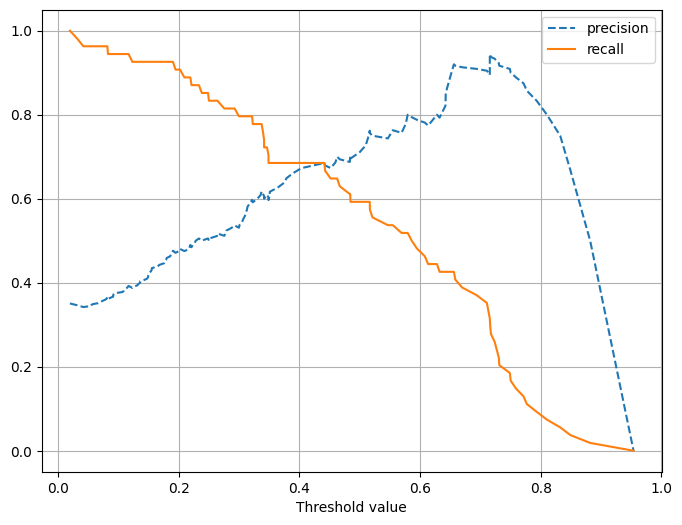

In [25]:
# Precision Recall Curve
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1] # 1로 예측할 확률
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

plt.figure(figsize = (8, 6))
plt.plot(thresholds, precisions[:len(thresholds)],
         linestyle = '--', label = 'precision')
plt.plot(thresholds, recalls[:len(thresholds)], label = 'recall')
plt.xlabel('Threshold value')
plt.legend(); plt.grid()
plt.show()

# threshold 0.7 이상이면 precision이 급격히 떨어짐

In [22]:
# describe()로 통계값들 확인
diabetes_data.describe()

# min 부분 : 임신횟수/인슐린/가족력/outcome은 0일 수 있으나, 글루코스/혈압/피하지방/BMI는 0일 수는 없음
# 빈칸은 없지만 0이면 안 되는 feature들이 있음

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

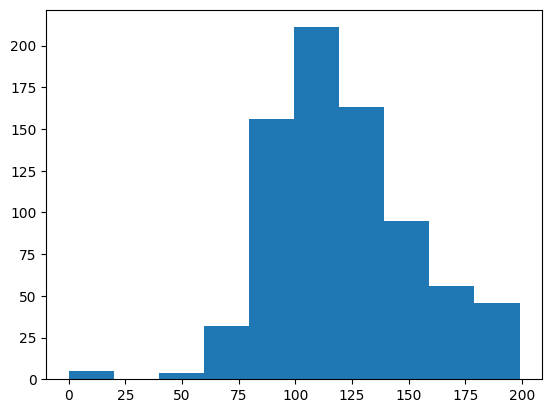

In [23]:
# 히스토그램 조사
plt.hist(diabetes_data['Glucose'], bins = 10)

In [26]:
# 각 column별 0의 개수 조사
(diabetes_data == 0).astype(int).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [27]:
# 0인 데이터를 각 column의 평균값으로 강제 조정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data[zero_features] = \
diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

In [28]:
# 데이터 조정 후 0의 개수 조사
(diabetes_data == 0).astype(int).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [29]:
# 다시 학습
y = diabetes_data['Outcome'].values
X = diabetes_data.iloc[:, :-1].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = \
train_test_split(X_scaled, y, test_size = 0.2,
                 random_state = 156, stratify = y)

lr_clf = LogisticRegression(random_state = 13, solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

In [30]:
# 주요 성능 확인
print('Accuracy : ', accuracy_score(y_test, pred))
print('Recall : ', recall_score(y_test, pred))
print('Precision : ', precision_score(y_test, pred))
print('AUC socre : ', roc_auc_score(y_test, pred))
print('f1_score : ', f1_score(y_test, pred))

Accuracy :  0.7987012987012987
Recall :  0.6111111111111112
Precision :  0.7674418604651163
AUC socre :  0.7555555555555556
f1_score :  0.6804123711340206


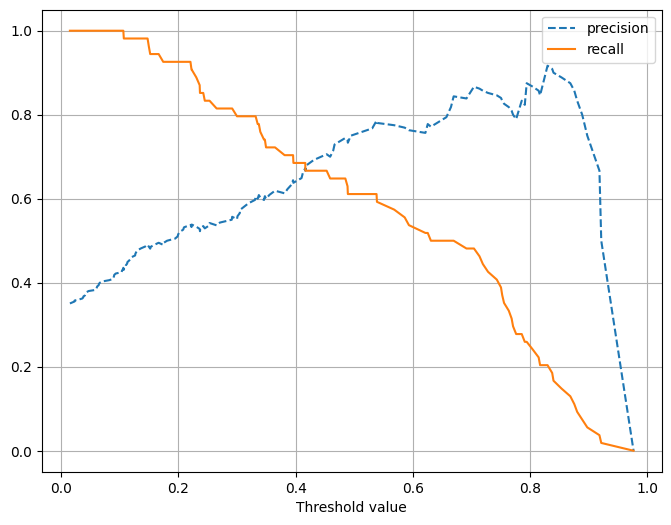

In [32]:
# Precision Recall Curve 확인
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

plt.figure(figsize = (8, 6))
plt.plot(thresholds, precisions[:len(thresholds)],
         linestyle = '--', label = 'precision')
plt.plot(thresholds, recalls[:len(thresholds)], label = 'recall')
plt.xlabel('Threshold value')
plt.legend(); plt.grid()
plt.show()

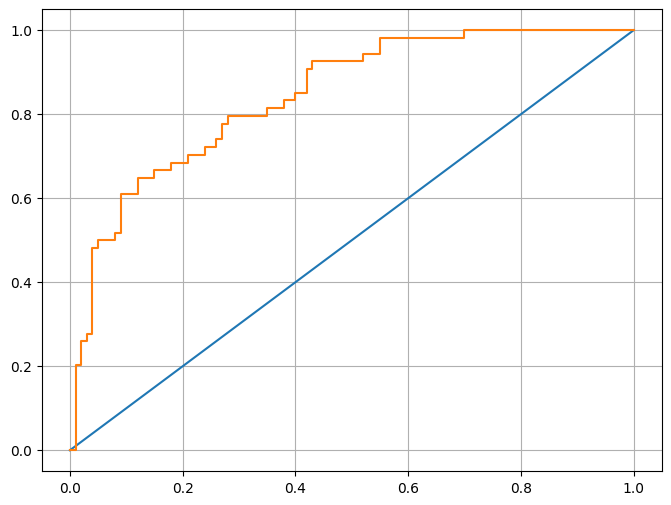

In [33]:
# ROC Curve 확인
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
fall_out, recall, threshold = roc_curve(y_test, pred_proba)

plt.figure(figsize = (8, 6))
plt.plot([0, 1], [0, 1])
plt.plot(fall_out, recall)
plt.grid()
plt.show()